# Problem
- Use BERT and XLNet to classify sentiment from vietnamese students reviews.

## Download dataset
Vietnamese Students' Feedback Corpus (UIT-VSFC) is the resource consists of over 16,000 sentences which are human-annotated with two different tasks: sentiment-based and topic-based classifications.

[1] Kiet Van Nguyen, Vu Duc Nguyen, Phu Xuan-Vinh Nguyen, Tham Thi-Hong Truong, Ngan Luu-Thuy Nguyen, UIT-VSFC: Vietnamese Students' Feedback Corpus for Sentiment Analysis,  2018 10th International Conference on Knowledge and Systems Engineering (KSE 2018), November 1-3, 2018, Ho Chi Minh City, Vietnam

In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("uitnlp/vietnamese_students_feedback")

## Train set exploration

In [3]:
train_set = dataset['train']
train_set

Dataset({
    features: ['sentence', 'sentiment', 'topic'],
    num_rows: 11426
})

In [4]:
train_set[0]

{'sentence': 'slide giáo trình đầy đủ .', 'sentiment': 2, 'topic': 1}

In [5]:
len(train_set)

11426

In [6]:
# Unique labels
set(train_set['sentiment'])

{0, 1, 2}

In [7]:
# Unique labels
set(train_set['topic'])

{0, 1, 2, 3}

In [8]:
# Giảm số lượng mẫu dữ liệu
train_set = train_set.select(range(5000))

## Test set exploration

In [9]:
test_set = dataset['test']
test_set

Dataset({
    features: ['sentence', 'sentiment', 'topic'],
    num_rows: 3166
})

In [10]:
test_set[0]

{'sentence': 'nói tiếng anh lưu loát .', 'sentiment': 2, 'topic': 0}

In [11]:
len(test_set)

3166

# Valid set exploration

In [12]:
valid_set = dataset['validation']

In [13]:
valid_set[0]

{'sentence': 'giáo trình chưa cụ thể .', 'sentiment': 0, 'topic': 1}

In [14]:
len(valid_set)

1583

# Question:

For both BERT - XLNet and vietnamese texts (this homework) and english texts (previous homework):
- Are there any differences in the evaluating performance in applying those 2 models for 2 datasets, i.e., vietnamese and english ? Analyze and visualize your results to prove your conclusion.
- How to improve the weaker approaches ?

## Valid set

# Load and Discover Dataset

In [43]:
# Load and discover datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd

class DatasetLoader:
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        self.dataset = None

    def load(self):
        self.dataset = load_dataset(self.dataset_name)
        return self.dataset

    def discover(self):
        if self.dataset is None:
            print("Dataset not loaded yet. Call load() first.")
            return

        print(f"Dataset Name: {self.dataset_name}")
        print("Available Splits:")
        for split_name in self.dataset:
            print(f"- {split_name}: {len(self.dataset[split_name])} examples")
            print(f"  Example: {self.dataset[split_name][0]}")

        print(f"Review length distribution: ")
        for split_name in self.dataset:
            review_len = [len(review.split()) for review in self.dataset[split_name]['sentence']]
            plt.figure(figsize=(10, 5))
            plt.hist(review_len, bins=50)
            plt.title(f"Review Length Distribution ({split_name})")
            plt.xlabel("Review Length")
            plt.ylabel("Count")
            plt.show()

            print(f"Average review length for {split_name}: {sum(review_len)/len(review_len)}")
            print(f"Max review length for {split_name}: {max(review_len)}")
            print(f"Min review length for {split_name}: {min(review_len)}")

        print("Label Distribution")
        for split_name in self.dataset:
            value_counts = pd.Series(self.dataset[split_name]['sentiment']).value_counts()
            plt.figure(figsize=(5, 3))
            plt.bar(x=value_counts.keys(), height=value_counts.values)
            plt.title(f"Lable Distribution ({split_name})")
            plt.xticks(ticks=value_counts.keys())
            plt.xlabel("Label")
            plt.ylabel("Count")
            plt.show()

Dataset Name: uitnlp/vietnamese_students_feedback
Available Splits:
- train: 11426 examples
  Example: {'sentence': 'slide giáo trình đầy đủ .', 'sentiment': 2, 'topic': 1}
- validation: 1583 examples
  Example: {'sentence': 'giáo trình chưa cụ thể .', 'sentiment': 0, 'topic': 1}
- test: 3166 examples
  Example: {'sentence': 'nói tiếng anh lưu loát .', 'sentiment': 2, 'topic': 0}
Review length distribution: 


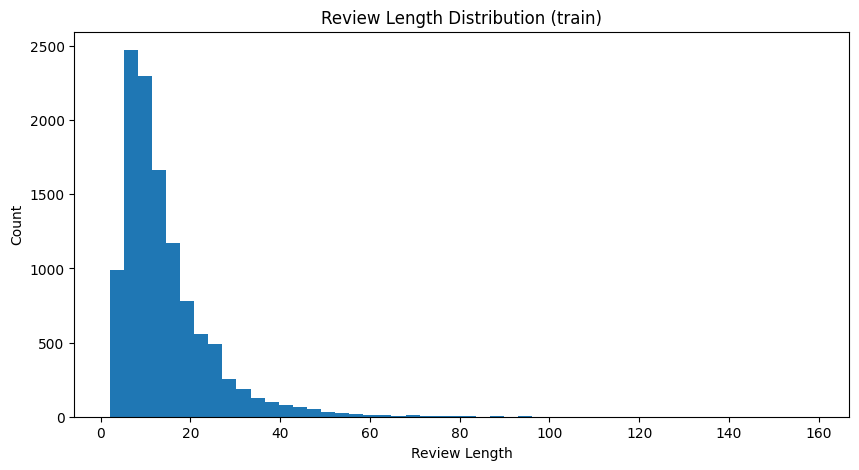

Average review length for train: 14.308769473131454
Max review length for train: 159
Min review length for train: 2


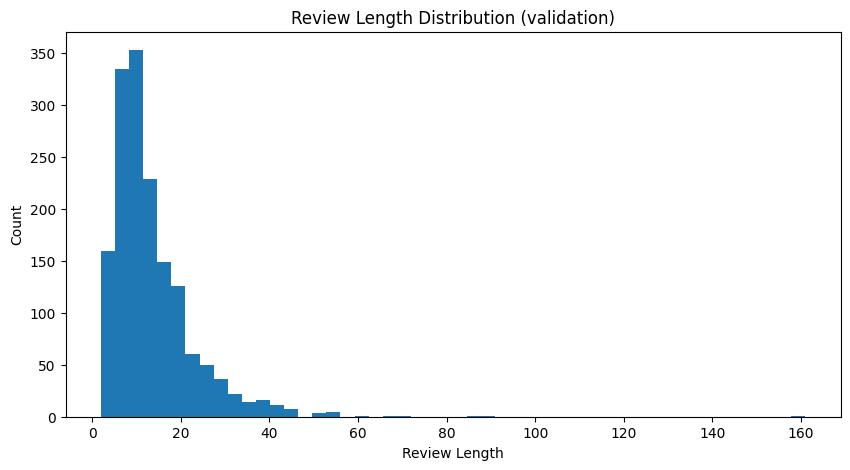

Average review length for validation: 13.67150979153506
Max review length for validation: 161
Min review length for validation: 2


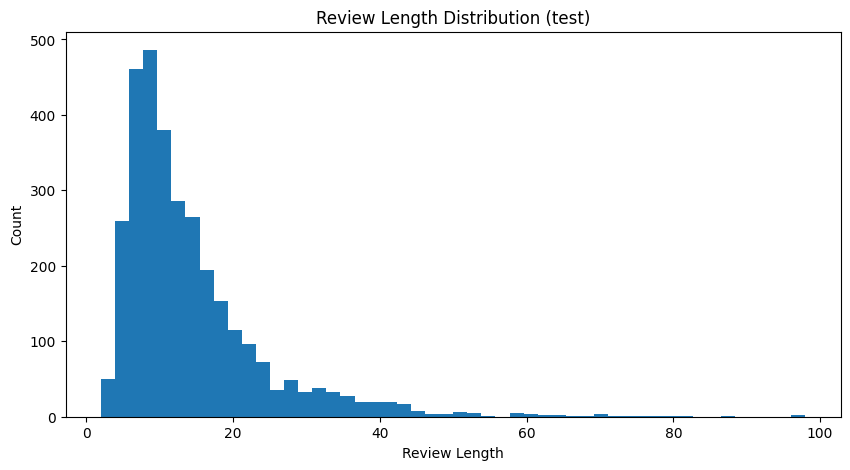

Average review length for test: 14.2207833228048
Max review length for test: 98
Min review length for test: 2
Label Distribution


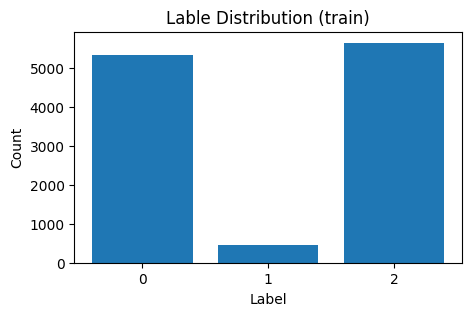

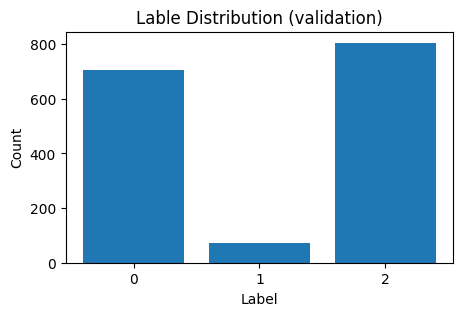

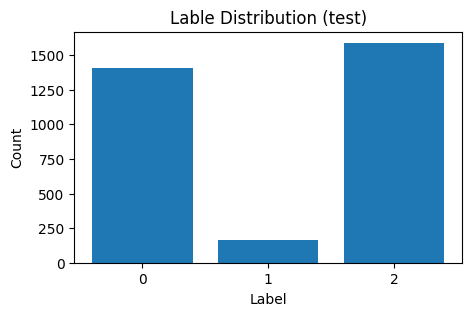

In [44]:
loader = DatasetLoader("uitnlp/vietnamese_students_feedback")
dataset = loader.load()
loader.discover()

# Preprocess Data

In [47]:
# Preprocessing
import re

class Preprocessor:
    def __init__(self, lowercase=True, remove_html=True, remove_numbers=True, remove_special_chars=True):
        self.lowercase = lowercase
        self.remove_html = remove_html
        self.remove_numbers = remove_numbers
        self.remove_special_chars = remove_special_chars

    def preprocess_text(self, text):
        if self.lowercase:
            text = text.lower()

        if self.remove_html:
            text = re.sub(r"<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>", '', text)

        if self.remove_numbers:
            text = re.sub(r"[0-9]", "", text)

        if self.remove_special_chars:
            text = re.sub(r"[^a-zA-Z\s\.\,\-]", "", text)

        text = re.sub(r"\s+", " ", text).strip()

        return text

    def preprocess_dataset(self, dataset):
        processed_dataset = dataset.map(lambda example: {'sentence': self.preprocess_text(example['sentence'])},)
        return processed_dataset

In [48]:
dataset = Preprocessor().preprocess_dataset(dataset)
train_set = dataset["train"].select(range(5000))
test_set = dataset["test"]

Map:   0%|          | 0/11426 [00:00<?, ? examples/s]

Map:   0%|          | 0/1583 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

# Tokenize data

In [15]:
# Tokenize dữ liệu
from transformers import BertTokenizerFast
from transformers import XLNetTokenizerFast

class Tokenizer:
    def __init__(self, model_name, max_length=128):
        if 'bert' in model_name:
            self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
        elif 'xlnet' in model_name:
            self.tokenizer = XLNetTokenizerFast.from_pretrained(model_name)
        self.max_length = max_length

    def tokenize_function(self, examples):
        texts = examples.get('sentence', examples.get('text'))
        return self.tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=self.max_length
        )

In [16]:
tokenizer = Tokenizer('bert-base-uncased')

train_set = train_set.map(tokenizer.tokenize_function, batched=True).rename_column("sentiment", "labels")
valid_set = valid_set.map(tokenizer.tokenize_function, batched=True).rename_column("sentiment", "labels")
test_set = test_set.map(tokenizer.tokenize_function, batched=True).rename_column("sentiment", "labels")

train_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
valid_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1583 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

# Create Dataloader

In [17]:
# Create a DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set, batch_size=16, num_workers=8, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=16, num_workers=8, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=16, num_workers=8, shuffle=True)

# Build and load model

In [18]:
# Build Model
from torch.optim import AdamW
from transformers import BertForSequenceClassification, XLNetForSequenceClassification

class ModelBuilder:
    def __init__(self, model_name, num_labels=3):
        if 'bert' in model_name:
            self.model_class = BertForSequenceClassification
        elif 'xlnet' in model_name:
            self.model_class = XLNetForSequenceClassification
        self.model_name = model_name
        self.num_labels = num_labels
        self.model = None

    def build_model(self):
        self.model = self.model_class.from_pretrained(self.model_name, num_labels=self.num_labels)
        return self.model
    
    def optimizer(self, learning_rate=5e-5):
        return AdamW(self.model.parameters(), lr=learning_rate)

In [19]:
# Load Model
bert_model_builder = ModelBuilder('bert-base-uncased', num_labels=3)
bert_model = bert_model_builder.build_model()
bert_optimizer = bert_model_builder.optimizer()

xlnet_model_builder = ModelBuilder('xlnet-base-cased', num_labels=3)
xlnet_model = xlnet_model_builder.build_model()
xlnet_optimizer = xlnet_model_builder.optimizer()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train model

In [ ]:
# Train the model
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class TrainerBuilder:
    def __init__(self, model, train_dataloader, valid_dataloader, optimizer, epochs=1):
        self.model = model
        self.train_dataset = train_dataloader.dataset
        self.valid_dataset = valid_dataloader.dataset
        self.epochs = epochs
        self.optimizer = optimizer

    def train(self):
        # Set up hyperparameters for training procedure
        training_args = TrainingArguments(
            output_dir="./results",
            logging_strategy="no",
            per_device_train_batch_size=8,
            num_train_epochs=self.epochs,
            weight_decay=0.01,
            logging_dir="./logs",
            evaluation_strategy="no",
            save_strategy="no"
        )

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.valid_dataset,
            optimizers=(self.optimizer, None)
        )

        trainer.train()
        return trainer

# Evaluate model

In [ ]:
# Evaluate the model
class Evaluator:
    def __init__(self, model, eval_dataloader, optimizer):
        self.model = model
        self.eval_dataset = eval_dataloader.dataset
        self.optimizer = optimizer

    def evaluate(self):
        eval_args = TrainingArguments(
            output_dir="./results_eval",
            per_device_eval_batch_size=8,
            evaluation_strategy="epoch",
            save_strategy="no",
            logging_dir="./logs_eval"
        )

        trainer = Trainer(
            model=self.model,
            args=eval_args,
            eval_dataset=self.eval_dataset,
            compute_metrics=lambda p: {
                'accuracy': accuracy_score(np.argmax(p.predictions, axis=1), p.label_ids),
                'f1': precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[2],
                'precision': precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[0],
                'recall': precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[1]
            },
            optimizers=(self.optimizer, None)
        )

        metrics = trainer.evaluate()
        return metrics

# Vietnamese Text

## BERT model

In [22]:
# Train
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
trainer_builder = TrainerBuilder(bert_model, train_dataloader, valid_dataloader, bert_optimizer)
trainer = trainer_builder.train()

  0%|          | 0/625 [00:00<?, ?it/s]

{'loss': 0.4919, 'grad_norm': 6.155267238616943, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 0.3852715790271759, 'eval_runtime': 14.8424, 'eval_samples_per_second': 106.654, 'eval_steps_per_second': 13.34, 'epoch': 1.0}
{'train_runtime': 172.6604, 'train_samples_per_second': 28.959, 'train_steps_per_second': 3.62, 'train_loss': 0.4919158203125, 'epoch': 1.0}


In [23]:
# Evaluate
evaluator = Evaluator(bert_model, test_dataloader, bert_optimizer)
print(evaluator.evaluate())

  0%|          | 0/396 [00:00<?, ?it/s]

{'eval_loss': 0.454088419675827, 'eval_accuracy': 0.8600758054327227, 'eval_f1': 0.8367833204480498, 'eval_precision': 0.8157707759362268, 'eval_recall': 0.8600758054327227, 'eval_runtime': 29.4227, 'eval_samples_per_second': 107.604, 'eval_steps_per_second': 13.459}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [24]:
metrics = evaluator.evaluate()
vn_bert_accuracy = metrics.get('eval_accuracy')
vn_bert_f1 = metrics.get('eval_f1')
vn_bert_precision = metrics.get('eval_precision')
vn_bert_recall = metrics.get('eval_recall')

  0%|          | 0/396 [00:00<?, ?it/s]

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## XLNet model

In [25]:
# Train
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlnet_model.to(device)
trainer_builder = TrainerBuilder(xlnet_model, train_dataloader, valid_dataloader, xlnet_optimizer)
trainer = trainer_builder.train()

  0%|          | 0/625 [00:00<?, ?it/s]

{'loss': 0.5439, 'grad_norm': 5.512360095977783, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 0.4647887051105499, 'eval_runtime': 19.4671, 'eval_samples_per_second': 81.317, 'eval_steps_per_second': 10.171, 'epoch': 1.0}
{'train_runtime': 805.3588, 'train_samples_per_second': 6.208, 'train_steps_per_second': 0.776, 'train_loss': 0.54392158203125, 'epoch': 1.0}


In [26]:
# Evaluate
evaluator = Evaluator(xlnet_model, test_dataloader, xlnet_optimizer)
print(evaluator.evaluate())

  0%|          | 0/396 [00:00<?, ?it/s]

{'eval_loss': 0.5061424970626831, 'eval_accuracy': 0.844914718888187, 'eval_f1': 0.8222744210534896, 'eval_precision': 0.8026797955607052, 'eval_recall': 0.844914718888187, 'eval_runtime': 42.1931, 'eval_samples_per_second': 75.036, 'eval_steps_per_second': 9.385}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [27]:
metrics = evaluator.evaluate()
vn_xlnet_accuracy = metrics.get('eval_accuracy')
vn_xlnet_f1 = metrics.get('eval_f1')
vn_xlnet_precision = metrics.get('eval_precision')
vn_xlnet_recall = metrics.get('eval_recall')

  0%|          | 0/396 [00:00<?, ?it/s]

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# English Text

In [28]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")

In [31]:
# Prepare IMDB dataset
imdb_train_set = imdb_dataset["train"].select(range(10000))
imdb_test_set = imdb_dataset["test"].select(range(5000))
imdb_valid_set = imdb_dataset["train"].select(range(20000, 25000))

In [32]:
# Tokenize the IMDB dataset
tokenizer = Tokenizer('bert-base-uncased')
imdb_train_set = imdb_train_set.map(tokenizer.tokenize_function, batched=True).rename_column("label", "labels")
imdb_valid_set = imdb_valid_set.map(tokenizer.tokenize_function, batched=True).rename_column("label", "labels")
imdb_test_set = imdb_test_set.map(tokenizer.tokenize_function, batched=True).rename_column("label", "labels")
imdb_train_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
imdb_valid_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
imdb_test_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

## Bert Model

In [33]:
from torch.utils.data import DataLoader

imdb_train_dataloader = DataLoader(imdb_train_set, batch_size=16, num_workers=8, shuffle=True)
imdb_valid_dataloader = DataLoader(imdb_valid_set, batch_size=16, num_workers=8, shuffle=True)
imdb_test_dataloader = DataLoader(imdb_test_set, batch_size=16, num_workers=8, shuffle=True)
# Train on IMDB dataset
imdb_trainer_builder = TrainerBuilder(bert_model, imdb_train_dataloader, imdb_valid_dataloader, bert_optimizer)
imdb_trainer = imdb_trainer_builder.train()
# Evaluate on IMDB dataset
imdb_evaluator = Evaluator(bert_model, imdb_test_dataloader, bert_optimizer)
print(imdb_evaluator.evaluate())

  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 0.0007, 'grad_norm': 0.0014088175958022475, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 10.743939399719238, 'eval_runtime': 47.6745, 'eval_samples_per_second': 104.878, 'eval_steps_per_second': 13.11, 'epoch': 1.0}
{'train_runtime': 858.3427, 'train_samples_per_second': 11.65, 'train_steps_per_second': 1.456, 'train_loss': 0.0006985436916351318, 'epoch': 1.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 4.563382390188053e-05, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 48.8801, 'eval_samples_per_second': 102.291, 'eval_steps_per_second': 12.786}


In [34]:
metrics = imdb_evaluator.evaluate()
en_bert_accuracy = metrics.get('eval_accuracy')
en_bert_f1 = metrics.get('eval_f1')
en_bert_precision = metrics.get('eval_precision')
en_bert_recall = metrics.get('eval_recall')

  0%|          | 0/625 [00:00<?, ?it/s]

## XLNet Model

In [35]:
# Train on XLNet model for IMDB dataset
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlnet_model.to(device)
trainer_builder = TrainerBuilder(xlnet_model, imdb_train_dataloader, imdb_valid_dataloader, xlnet_optimizer)
trainer = trainer_builder.train()

  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 0.0002, 'grad_norm': 0.0003681641537696123, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 13.107901573181152, 'eval_runtime': 63.2183, 'eval_samples_per_second': 79.091, 'eval_steps_per_second': 9.886, 'epoch': 1.0}
{'train_runtime': 2463.1335, 'train_samples_per_second': 4.06, 'train_steps_per_second': 0.507, 'train_loss': 0.00024531548023223876, 'epoch': 1.0}


In [36]:
# Evaluate on XLNet model for IMDB dataset
imdb_evaluator = Evaluator(xlnet_model, imdb_test_dataloader, xlnet_optimizer)
print(imdb_evaluator.evaluate())

  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 4.653204086935148e-06, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 66.1704, 'eval_samples_per_second': 75.562, 'eval_steps_per_second': 9.445}


In [37]:
metrics = imdb_evaluator.evaluate()
en_xlnet_accuracy = metrics.get('eval_accuracy')
en_xlnet_f1 = metrics.get('eval_f1')
en_xlnet_precision = metrics.get('eval_precision')
en_xlnet_recall = metrics.get('eval_recall')

  0%|          | 0/625 [00:00<?, ?it/s]

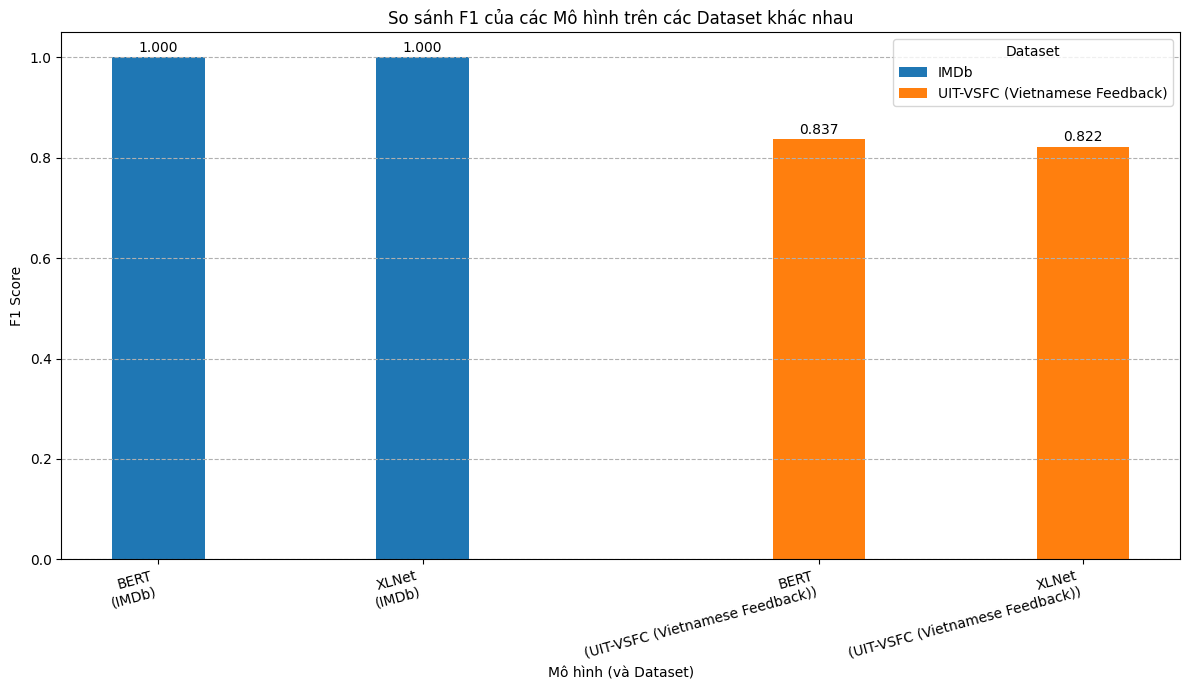

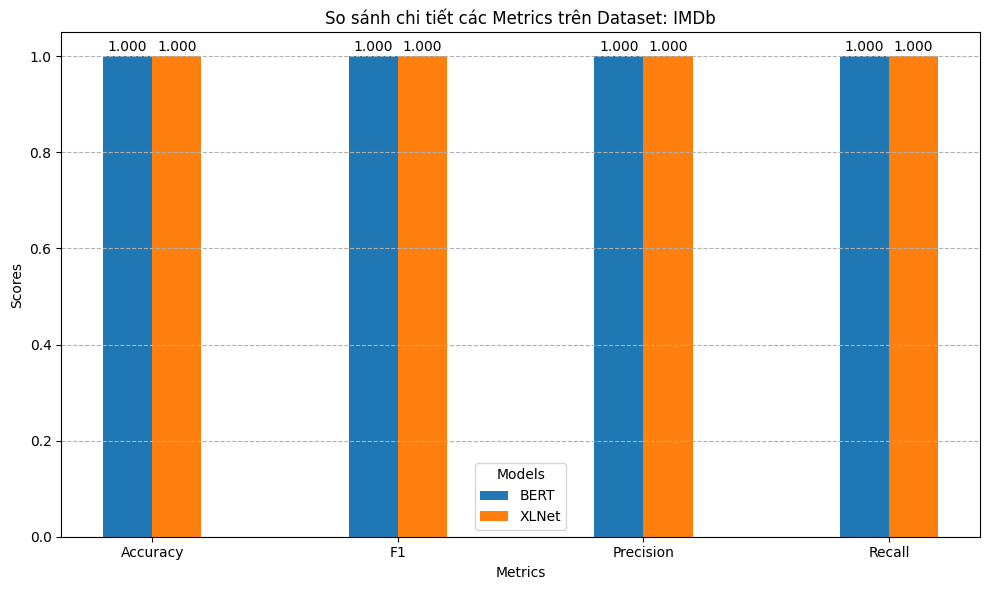

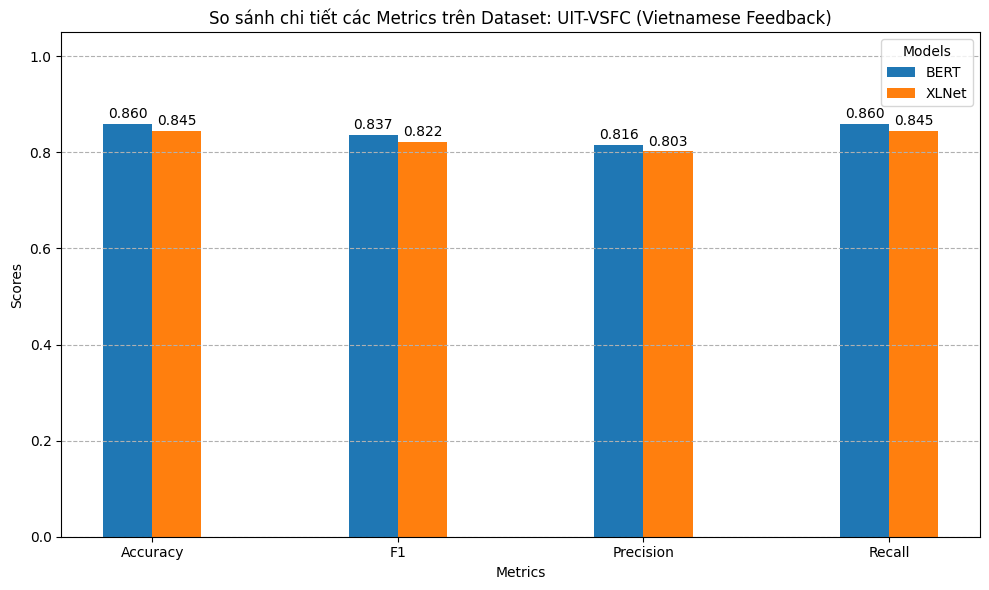

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu kết quả giả định (như trên)
results_data = {
    'IMDb': {
        'BERT': {'accuracy': en_bert_accuracy, 'f1': en_bert_f1, 'precision': en_bert_precision, 'recall': en_bert_recall},
        'XLNet': {'accuracy': en_xlnet_accuracy, 'f1': en_xlnet_f1, 'precision': en_xlnet_precision, 'recall': en_xlnet_recall},
    },
    'UIT-VSFC (Vietnamese Feedback)': {
        'BERT': {'accuracy': vn_bert_accuracy, 'f1': vn_bert_f1, 'precision': vn_bert_precision, 'recall': vn_bert_recall},
        'XLNet': {'accuracy': vn_xlnet_accuracy, 'f1': vn_xlnet_f1, 'precision': vn_xlnet_precision, 'recall': vn_xlnet_recall},
    }
}

# --- Biểu đồ 1: So sánh F1-score của các model trên từng dataset ---
datasets = list(results_data.keys())
metrics_to_plot = ['f1']

for metric_name in metrics_to_plot:
    plt.figure(figsize=(12, 7))
    bar_width = 0.35
    index = 0

    all_model_names = []
    all_scores = []
    all_dataset_names_for_ticks = []

    for i, dataset_name in enumerate(datasets):
        models_in_dataset = list(results_data[dataset_name].keys())
        scores = [results_data[dataset_name][model][metric_name] for model in models_in_dataset]

        x_positions = np.arange(len(models_in_dataset)) + index
        bars = plt.bar(x_positions, scores, bar_width, label=f'{dataset_name}')

        for bar_idx, bar in enumerate(bars):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')
            all_model_names.append(f"{models_in_dataset[bar_idx]}\n({dataset_name})")
        index += len(models_in_dataset) + 0.5

    plt.xlabel("Mô hình (và Dataset)")
    plt.ylabel(f"{metric_name.capitalize()} Score")
    plt.title(f"So sánh {metric_name.capitalize()} của các Mô hình trên các Dataset khác nhau")

    # Tạo nhãn trục x dựa trên các mô hình và dataset
    tick_positions = []
    current_pos = 0
    for dataset_name in datasets:
        models_in_dataset = list(results_data[dataset_name].keys())
        num_models = len(models_in_dataset)
        tick_positions.extend(np.arange(num_models) + current_pos)
        current_pos += num_models + 0.5

    plt.xticks(tick_positions, all_model_names, rotation=15, ha="right")
    plt.ylim(0, 1.05)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--')
    plt.show()

# --- Biểu đồ 2: So sánh chi tiết các metrics (Accuracy, F1, Precision, Recall) cho từng dataset ---
for dataset_name, models_data in results_data.items():
    model_names = list(models_data.keys())
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    num_metrics = len(metrics)
    num_models = len(model_names)

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.20
    index = np.arange(num_metrics)

    for i, model_name in enumerate(model_names):
        scores = [models_data[model_name][metric] for metric in metrics]
        # Vị trí của các cột cho model hiện tại
        positions = index + i * bar_width
        bars = ax.bar(positions, scores, bar_width, label=model_name)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Scores")
    ax.set_title(f"So sánh chi tiết các Metrics trên Dataset: {dataset_name}")
    ax.set_xticks(index + bar_width * (num_models - 1) / 2)
    ax.set_xticklabels([m.capitalize() for m in metrics])
    ax.legend(title="Models")
    ax.set_ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

# Answer Question:
### Sự khác biệt giữa 2 tập dữ liệu:
1. Trên tập Tiếng Anh (imdb_dataset):
- Nhãn dự đoán gồm 2 class, nhưng số lượng mẫu nhiều hơn so với tập Tiếng Việt.
- Mô hình Bert và XLNet đều cho ra hiệu suất rất tốt với bộ dữ liệu đã giảm bớt số lượng mẫu.
- Nguyên nhân: Dữ liệu đánh giá phim trên IMDb thường có cấu trúc câu cú rõ ràng và từ vựng tương đối chuẩn, giúp mô hình dễ dàng nắm bắt các tín hiệu cảm xúc hơn so với ngôn ngữ đời thường hay teencode.

2. Trên dữ liệu Tiếng Việt (uitnlp/vietnamese_students_feedback):
- Tuy nhãn dự đoán gồm 3 class, nhưng số lượng mẫu ít hơn so với tập Tiếng Anh.
- Mô hình Bert có hiệu suất tốt hơn XLNet một chút.
- Nguyên nhân: Mô hình Bert được huấn luyện bằng tiếng việt nhiều hơn so với Bert. Lớp 'Trung Tính' thường rất khó phân biệt vì nó có thể chứa các câu không cảm xúc, hoặc cảm xúc không rõ ràng, dễ bị nhầm lẫn với hai lớp còn lại. Số lượng mẫu ít trên mỗi lớp cũng khiến mô hình khó học được các đặc trưng đủ mạnh.

### Cách cải thiện các phương pháp yếu hơn
- Cải thiện Dữ liệu (Data-Centric)
Tăng cường dữ liệu (Data Augmentation): Tạo thêm dữ liệu huấn luyện từ dữ liệu hiện có bằng các kỹ thuật như Back-Translation (dịch sang ngôn ngữ khác rồi dịch ngược lại) hoặc thay thế từ đồng nghĩa.
Làm sạch và Tiền xử lý kỹ lưỡng: Đảm bảo dữ liệu không có nhiễu, chuẩn hóa text (ví dụ: xử lý emoji, teencode), và sử dụng tokenizer phù hợp với ngôn ngữ.
- Cải thiện Mô hình (Model-Centric)
Chọn Pre-trained Model tốt hơn: Đây là cách hiệu quả nhất. Đối với tiếng Việt, nếu một mô hình đa ngôn ngữ hoạt động kém, hãy chuyển ngay sang PhoBERT.
Domain-Adaptive Pre-training: Nếu bạn có một lượng lớn dữ liệu văn bản chưa gán nhãn thuộc cùng lĩnh vực (ví dụ: rất nhiều bình luận của sinh viên), bạn có thể tiếp tục pre-train mô hình đã chọn trên dữ liệu này trước khi fine-tuning. Việc này giúp mô hình "làm quen" với văn phong và từ vựng của lĩnh vực đó.
Thử nghiệm các kiến trúc mới hơn: Các mô hình như DeBERTa, ELECTRA thường cho kết quả tốt hơn các thế hệ trước.
- Cải thiện Quy trình Huấn luyện (Training-Process-Centric)
Tối ưu Siêu tham số (Hyperparameter Tuning): Dùng các công cụ như Optuna hoặc Ray Tune để tự động tìm ra bộ siêu tham số tốt nhất cho learning_rate, batch_size, weight_decay...